# Description

It generates different general plots to compare coefficient values from Pearson, Spearman and Clustermatch, such as their distribution.

In `Settings` below, the data set and other options (such as tissue for GTEx) are specified.

# Modules

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns

from clustermatch.plots import plot_histogram, plot_cumulative_histogram, jointplot
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.GTEX
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

In [3]:
# this is used for the cumulative histogram
GENE_PAIRS_PERCENT = 0.70

# Paths

In [4]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [5]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / f"gtex_{GTEX_TISSUE}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_whole_blood')

In [6]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [7]:
INPUT_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_FILE)

assert INPUT_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-all.pkl')

# Data

In [8]:
df = pd.read_pickle(INPUT_FILE)

In [9]:
df.shape

(12497500, 3)

In [10]:
df.head()

clustermatch   pearson  spearman
ENSG00000000419.12 ENSG00000002834.17      0.418721  0.681847  0.786595
                   ENSG00000002919.14      0.405090  0.734699  0.816991
                   ENSG00000002933.7       0.007466  0.013825  0.004128
                   ENSG00000003402.19      0.391683  0.727347  0.803653
                   ENSG00000004478.7       0.099013  0.094147  0.231269

## Data stats

In [11]:
df.describe().applymap(str)

,clustermatch,pearson,spearman
count,12497500.0,12497500.0,12497500.0
mean,0.14078162169144154,0.3055270339582277,0.39444206469877185
std,0.14482154321798,0.24329624620596305,0.2595310853531984
min,0.0,1.5077467052648785e-08,1.3941559573460438e-08
25%,0.02840489656767938,0.09442322140732318,0.16297401304506182
50%,0.0811105958507932,0.23886133272185917,0.3675595119633454
75%,0.2167198284523933,0.4953853540480224,0.6148954029591087
max,0.9169180125916612,0.9948779504715451,0.9867424080828916


In [12]:
# skewness
df.apply(lambda x: stats.skew(x))

clustermatch    1.283771
pearson         0.622893
spearman        0.245173
dtype: float64

# Histogram plot

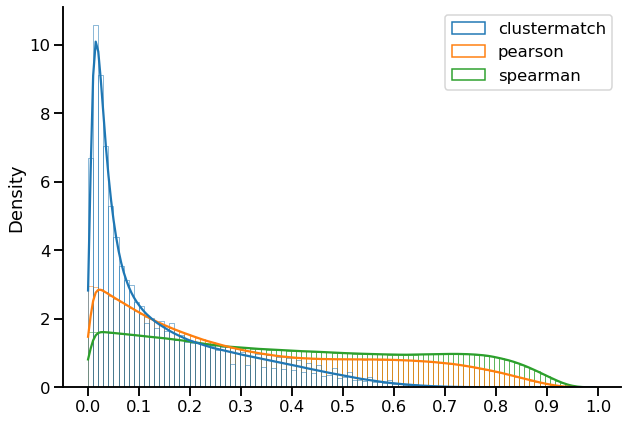

In [13]:
with sns.plotting_context("talk", font_scale=1.0):
    plot_histogram(df, output_dir=OUTPUT_FIGURE_DIR, fill=False)

Coefficients' values distribute very differently. Clustermatch is skewed to the left, whereas Pearson and specially Spearman seem more uniform.

# Cumulative histogram plot

I include also a cumulative histogram without specifying `bins`.

clustermatch    0.181940
pearson         0.434711
spearman        0.562740
Name: 0.7, dtype: float64

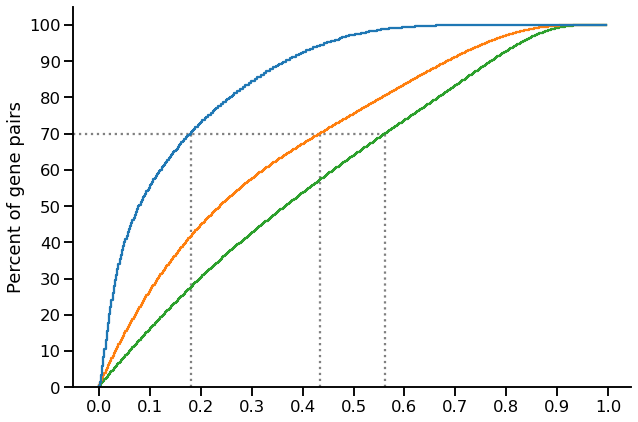

In [14]:
with sns.plotting_context("talk", font_scale=1.0):
    plot_cumulative_histogram(df, GENE_PAIRS_PERCENT, output_dir=OUTPUT_FIGURE_DIR)

# Joint plots comparing each coefficient

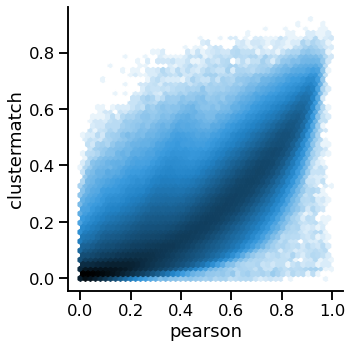

In [15]:
with sns.plotting_context("talk", font_scale=1.0):
    jointplot(
        data=df,
        x="pearson",
        y="clustermatch",
        add_corr_coefs=False,
        output_dir=OUTPUT_FIGURE_DIR,
    )

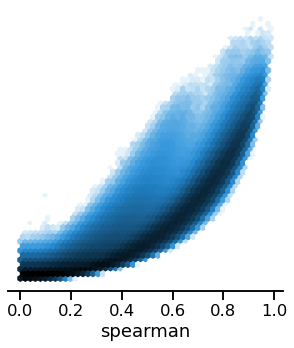

In [16]:
with sns.plotting_context("talk", font_scale=1.0):
    x, y = "spearman", "clustermatch"

    g = jointplot(
        data=df,
        x=x,
        y=y,
        add_corr_coefs=False,
    )

    sns.despine(ax=g.ax_joint, left=True)
    g.ax_joint.set_yticks([])
    g.ax_joint.set_ylabel(None)

    g.savefig(
        OUTPUT_FIGURE_DIR / f"dist-{x}_vs_{y}.svg",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

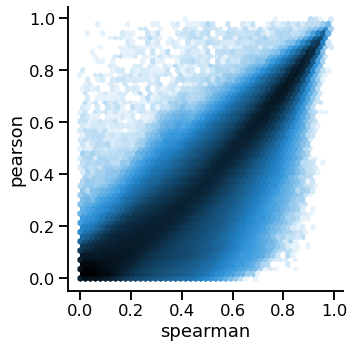

In [17]:
with sns.plotting_context("talk", font_scale=1.0):
    jointplot(
        data=df,
        x="spearman",
        y="pearson",
        add_corr_coefs=False,
        output_dir=OUTPUT_FIGURE_DIR,
    )